In [ ]:
import os, datetime, hashlib, subprocess, warnings
import numpy as np, pandas as pd
from sqlalchemy import create_engine, text
from scipy.special import expit
from collections import defaultdict
from scipy.stats import spearmanr, kendalltau
import tqdm
from scipy import stats

In [ ]:
EXCLUDE = {"PI0", "PI0_FAST"} #, "PALIGEMMA_FAST_DROID", "PALIGEMMA_FAST_SPECIALIST_DROID", "PALIGEMMA_DIFFUSION_DROID", "PALIGEMMA_VQ_DROID"}
T_BUCKET = 8 # discrete task buckets
TEST_FR = 0.20
EM_ITERS = 60
VERBOSE = False
rng = np.random.default_rng(0)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
# Helper functions

def canonical(x): return (x or "").strip()
def sha8(x): return hashlib.sha1(x.encode()).hexdigest()[:8]
def dbg(*a): print(*a) if VERBOSE else None
def safe_newton(x, g, h): return x - g / (h if abs(h) > 1e-8 else -1e-8)

def ci(scores, confidence=0.95):
    n = len(scores)
    sem = stats.sem(scores)  # Standard error of the mean
    ci = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return ci

def pearson(a, b):
    a, b = np.asarray(a), np.asarray(b)
    m = ~(np.isnan(a) | np.isnan(b))
    if m.sum() < 2: return np.nan
    a, b = a[m] - a[m].mean(), b[m] - b[m].mean()
    return (a @ b) / (np.linalg.norm(a) * np.linalg.norm(b) + 1e-8)

def mmrv(a, b):
    a, b = np.asarray(a), np.asarray(b)
    m = ~(np.isnan(a) | np.isnan(b))
    if m.sum() < 2: return np.nan
    a, b = a[m], b[m]
    return np.mean([
        max([abs(b[i] - b[j]) for j in range(len(a))
             if (a[i] > a[j]) != (b[i] > b[j])] or [0])
        for i in range(len(a))
    ])

def accuracy(df, board):
    sc = board.set_index("policy")["score"]
    ok = 0
    total = 0
    for _, r in df.iterrows():
        if r.y == 1: continue   # Don't measure accuracy on ties
        if r.i in sc and r.j in sc:
            total += 1
            pred = 2 if sc[r.i] > sc[r.j] else 0 # if sc[r.j] > sc[r.i] else 1
            ok += int(pred == r.y)
    return ok / total

# Pairwise accuracy (e.g., average accuracy on all n choose 2 pairs)
def pairwise_accuracy(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    mask = ~(np.isnan(a) | np.isnan(b))
    a, b = a[mask], b[mask]
    n = len(a)
    if n < 2:
        return np.nan
    correct = total = 0
    for i in range(n):
        for j in range(i+1, n):
            if b[i] == b[j]:
                continue
            total += 1
            if (a[i] - a[j]) * (b[i] - b[j]) > 0:
                correct += 1
    return correct / total if total else np.nan



In [ ]:
standard_droid_results = {
    "paligemma_fast_specialist_droid": [1.5/2, 2/2, 1/5/2, 1.5/2, 2/2, 2/2, 2/2, 2/2, 2/2, 2/2, 2/2, 2/2, 1/2, 1/2, 0/2, 0/2, 1/2, 1/2, 1/2, 1/2, 2/2, 2/2, 1/2, 2/2, 1/2, 1/2, 0/3, 1/3, 1.5/2, 2/2, 2/2, 2/2, 0/2, 0/2, 2/2, 2/2, 1/2, 0/2, 0/2, 0/2, 0/2, 0/2, 1/2, 2/2],
    "paligemma_fast_droid": [2/2, 1.5/2, 2/2, 2/2,  1/2, 1.5/2, 2/2, 2/2, 1.5/2, 0/2, 2/2,  2/2, 0/2, 0/2,  0/2, 1/2, 0/2, 1/2, 2/2, 0/2, 0/2, 1/2, 0/2, 0/2, 1/2, 0/2, 1/2, 0/3, 0/3, 2/2, 2/2, 1/2, 2/2 , 2/2,  1/2, 1/2, 1/2, 1/2,  1/2, 2/2, 2/2, 2/2, 1/2, 0/2, 0/2],
    "paligemma_vq_droid": [1.5/2, 1.5/2, 1.5/2, 1.5/2, 2/2, 1/2, 2/2, 2/2, 0/2, 1.5/2, 1/2, 2/2, 1/2, 1.5/2, 0/2, 0/2, 2/2, 1/2, 1/2, 1/2, 2/2, 2/2, 1/2, 1/2, 1/2, 1/2, 0/3, 1/3, 1.5/2, 2/2, 2/2, 2/2, 0/2, 0/2, 1/2, 1/2, 0/2, 0/2, 1/2, 0/2, 1/2, 2/2, 1/2, 2/2,
            2/2, 1.5/2, 1.5/2, 2/2, 2/2, 2/2, 1.5/2, 2/2, 2/2, 2/2, 0/2, 0/2, 0/2, 0/2, 2/2, 2/2, 0/2, 0/2, 2/2, 2/2, 1/2, 1/2, 1/2, 1/2, 2/3, 1/3, 2/2, 1.5/2, 2/2, 2/2, 0/2, 0/2, 2/2, 1/2, 0/2, 2/2, 2/2, 2/2, 2/2, 2/2],
    "paligemma_binning_droid": [0/2, 2/2, 0/2, 1/2, 2/2, 0/2, 0/2, 2/2, 2/2, 0/2, 1/2, 0/2, 2/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 1/2, 0/2, 0/2, 0/2, 0/2, 0/3, 0/3, 0/2, 0/2, 1.5/2, 0/2, 0/2,0/2, 1/2,0/2, 1/2,0/2, 0/2,1/2, 0/2,2/2, 0/2,0/2,
            0/2,0/2,2/2,0/2, 0/2,1/2,2/2,1/2, 0/2,1/2, 1/2,0/2, 0/2,0/2, 0/2,0/2, 0/2,0/2,0/2,0/2, 1/2,0/2, 0/2,0/2,1/2,1/2, 0/3,0/3, 1.5/2,1.5/2,1.5/2,0/2, 0/2,0/2, 1/2,0/2, 0/2,0/2, 1/2,0/2, 1/2,0/2, 0/2,0/2],
    "paligemma_diffusion_droid": [2/2, 2/2, 0/2, 1.5/2, 0/2, 1/2, 1/2, 1/2, 0/2, 0/2, 1/2, 0/2, 0/2, 0/2, 1/2, 1/2, 0/2, 0/2, 1/2, 1/2, 1/2, 1/2, 0/2, 1/2, 0/3, 0/3, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2, 0/2],
    "pi0_droid": [0/2, 0/2, 0/2, 1/2, 2/2, 2/2, 2/2, 0/2, 1.5/2, 1.5/2, 1/2, 1/2, 1/2, 1/2, 0/2, 0/2, 0/2, 1/2, 1/2, 0/2, 1/2, 1/2, 1/2, 0/2, 1/2, 1/2, 0/3, 2/2, 1/2, 1/2, 1.5/2, 0/2, 0/2, 2/2, 1/2, 0/2, 0/2, 0/2, 0/2, 1/2, 0/2, 2/2, 0/2],
    "pi0_fast_droid": [2/2, 1/2, 1.5/2, 1/2, 1/2, 0/2, 1/2, 1/2, 1/2, 2/2, 2/2, 2/2, 2/2, 2/2, 1.5/2, 0/2, 2/2, 0/2, 0/2, 0/2, 1/2, 1/2, 1/2, 1/2, 1/2, 0/2, 0/3, 0/3, 2/2, 2/2, 2/2, 2/2, 0/2, 0/2, 1/2, 2/2, 0/2, 1/2, 2/2, 2/2, 2/2, 2/2, 1/2, 0/2,
                          2/2, 2/2, 0/2, 1/2, 0/2, 1.5/2,  1/2, 1.5/2 , 2/2, 2/2, 2/2, 2/2, 1.5/2, 1/2, 0/2, 0/2, 1/2, 1/2, 2/2, 0/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/3, 1/3, 2/2, 2/2, 2/2, 2/2, 2/2, 0/2, 2/2, 1/2, 2/2, 2/2, 1/2, 1/2, 2/2, 2/2, 0/2, 0/2,
                          1.5/2, 2/2, 2/2, 2/2., 0/2, 1/2, 1.5/2, 2/2, 1/2, 1/2, 2/2, 2/2, 2/2, 0/2, 0/2, 1/2, 2/2, 2/2, 2/2, 1/2, 2/2, 1/2, 1/2, 1/2, 1/2, 1/2, 2/3, 2/3, 2/2, 2/2, 1/2, 2/2, 2/2, 0/2, 1/2, 1/2, 2/2, 1/2, 2/2, 2/2, 2/2, 0/2, 0/2, 0/2],
}
print(f"Total evals: {sum(len(v) for v in standard_droid_results.values())}")

Total evals: 476


In [ ]:
import pandas as pd

eps = pd.read_csv("episodes.csv.gz", compression="gzip")
ses = pd.read_csv("sessions.csv.gz", compression="gzip")

In [ ]:
eps[-5:]

,id,session_id,policy_name,command,binary_success,partial_success,duration,gcs_left_cam_path,gcs_right_cam_path,gcs_wrist_cam_path,npz_file_path,policy_ip,policy_port,third_person_camera_type,third_person_camera_id,feedback,timestamp
4686,4687,922,paligemma_binning_droid,place the shoes inside the box,0,0.00,80,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,41782,left_image,NaN,B;avg_latency=1.688,2025-04-30 00:47:24
4687,4689,922,paligemma_fast_specialist_droid,place the shoes inside the box,0,0.20,344,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,23203,left_image,NaN,D;avg_latency=0.874,2025-04-30 00:51:12
4688,4691,922,paligemma_vq_droid,place the shoes inside the box,0,0.00,88,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,NaN,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,evaluation_data/405c6c08-2136-4e76-9fd1-91cc88...,159.223.171.199,17945,left_image,NaN,F;avg_latency=0.858,2025-04-30 00:53:51
4689,4644,915,paligemma_fast_specialist_droid,pick the pliers and place it in the box,1,1.00,320,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,NaN,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,evaluation_data/bc04f9ef-f7bd-48bd-aa05-1b13f0...,159.223.171.199,23203,left_image,NaN,A;avg_latency=1.601,2025-04-29 19:48:46
4690,4646,916,paligemma_fast_specialist_droid,Put the bolt in the drawer.,0,0.25,288,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,evaluation_data/864e8ddb-9b63-4bf1-938c-0909bc...,159.223.171.199,23203,left_image,NaN,C;avg_latency=0.654,2025-04-29 10:50:17


In [ ]:
# Extract preference data
pairs = []
for _, r in ses.iterrows():
    if (not isinstance(r.evaluation_notes, str)
        or "VALID_SESSION" not in r.evaluation_notes):
      continue
    A, B = map(canonical, (r.policyA_name, r.policyB_name))
    if A.upper() in EXCLUDE or B.upper() in EXCLUDE: continue
    pref = None
    for line in (r.evaluation_notes or "").splitlines():
        line = line.strip().upper()
        if line.startswith("PREFERENCE="):
            pref = {"A": 2, "B": 0, "TIE": 1}[line.split("=")[1]]
            break
    if pref is not None:
        pairs.append((r.id, A, B, pref))
pref_df = pd.DataFrame(pairs, columns=["sid", "i", "j", "y"])
pref_df[-5:]

,sid,i,j,y
512,915,paligemma_fast_specialist_droid,paligemma_binning_droid,2
513,917,pi0_droid,paligemma_fast_specialist_droid,0
514,918,paligemma_diffusion_droid,paligemma_fast_specialist_droid,0
515,920,paligemma_vq_droid,paligemma_binning_droid,2
516,921,paligemma_binning_droid,pi0_droid,0


In [ ]:
# Extract per-policy data
from collections import Counter

rows = []
all_sess_ids = Counter()
for _, r in eps.iterrows():
    sess_id = r.session_id
    if sess_id not in pref_df.sid.unique(): continue
    # Don't use more than 2 examples from each session for fair comparison
    if all_sess_ids[sess_id] > 1: continue
    all_sess_ids[sess_id] += 1
    pol = canonical(r.policy_name)
    if pol.upper() in EXCLUDE: continue
    cmd = (r.command or "").strip()
    key = f"{cmd}"
    t = int(sha8(key), 16) % T_BUCKET
    win = int(float(r.partial_success or 0) >= 0.80) if pd.isna(r.binary_success) else int(r.binary_success)
    rows.append((pol, t, win, cmd, r.gcs_left_cam_path, sess_id, r.partial_success))
task_df = pd.DataFrame(rows, columns=["policy", "task", "win", "instr", "img", "sid", "partial_success"])
task_df[-5:]

,policy,task,win,instr,img,sid,partial_success
1029,paligemma_binning_droid,3,0,Set the table.,evaluation_data/c350b0ad-2de2-48b2-bdde-a98569...,910,0.0
1030,paligemma_vq_droid,1,0,pour the cup into the tape,evaluation_data/1d35d057-4813-4334-ac34-cd2a37...,911,0.2
1031,pi0_fast_droid,6,0,Finish setting the table.,evaluation_data/31050a60-de63-4f13-b1a6-26ce96...,912,0.0
1032,paligemma_fast_droid,1,0,pour the cup into the tape,evaluation_data/1d35d057-4813-4334-ac34-cd2a37...,911,0.6
1033,paligemma_diffusion_droid,6,0,Finish setting the table.,evaluation_data/31050a60-de63-4f13-b1a6-26ce96...,912,0.0


In [ ]:
# Train / Test Split
sid = np.unique(pref_df.sid)
rng.shuffle(sid)

train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]
print(f"#Train Pref: {len(train_pref)}, #Test Pref: {len(test_pref)}")

train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
test_task  = task_df[~task_df.sid.isin(train_task.sid)]
print(f"#Train Task: {len(train_task)}, #Test Task: {len(test_task)}")

#Train Pref: 413, #Test Pref: 104
#Train Task: 826, #Test Task: 208


In [ ]:
# Ground truth partial success scores
eps["policy_canon"] = eps.policy_name.apply(canonical)
gt = (
    eps[~eps.policy_canon.str.upper().isin(EXCLUDE)]
    .groupby("policy_canon")["partial_success"]
    .mean()
    .dropna()
    .reset_index()
    .rename(columns={"policy_canon": "policy", "partial_success": "gt"})
)

In [ ]:
def bootstrap(fn, use_pref=True, bootstrap_rounds=100):
  # Run algorithm over N random resamples of the data

  sid = np.unique(pref_df.sid)
  pol_scores = defaultdict(list)
  metrics = defaultdict(list)
  for _ in tqdm.tqdm(range(bootstrap_rounds)):
    rng.shuffle(sid)

    train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
    test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]

    train_data = train_pref
    test_data = test_pref
    if not use_pref:
      train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
      test_task  = task_df[~task_df.sid.isin(train_task.sid)]
      train_data = train_task

    # Run algorithm
    results = fn(train_data)
    for _, r in results.iterrows():
      pol_scores[r.policy].append(r.score)

    # Compute metrics
    merged = results.merge(gt, on="policy", how="inner")

    sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
    gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)
    acc = accuracy(test_data, results)
    gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
    metrics["pearson"].append(pearson(sc_vals, gt_vals))
    metrics["mmrv"].append(mmrv(sc_vals, gt_vals))
    metrics["accuracy"].append(acc)
    metrics["delta_accuracy"].append(max(gt_acc - acc, 0))

  mean_pol_scores = {pol: np.mean(scores) for pol, scores in pol_scores.items()}
  std_pol_scores = {pol: np.std(scores) for pol, scores in pol_scores.items()}
  policies = list(mean_pol_scores.keys())

  metrics = pd.DataFrame(
      {
          "metric": metrics.keys(),
          "score": [np.mean(scores) for scores in metrics.values()],
          "std": [np.std(scores) for scores in metrics.values()],
          "ci95": [ci(scores) for scores in metrics.values()]
      }
  )
  return (
      pd.DataFrame(
          {
              "policy": policies,
              "score": [mean_pol_scores[p] for p in policies],
              "std": [std_pol_scores[p] for p in policies]
          }
      )
      .sort_values("score", ascending=False)
      .reset_index(drop=True),
      metrics
  )

# Bradly-Terry Model

In [ ]:
def bt_mm(df, iters=200):
    # convert tie rows to two half-rows
    half = df[df.y == 1].copy()
    half["y"] = 2 # treat as win for i
    df_bt = pd.concat([df[df.y != 1], half], ignore_index=True)

    pols = pd.unique(pd.concat([df_bt.i, df_bt.j]))
    idx = {p: k for k, p in enumerate(pols)}
    m = len(pols)
    i = df_bt.i.map(idx).to_numpy()
    j = df_bt.j.map(idx).to_numpy()
    win = (df_bt.y == 2).to_numpy()

    θ = np.zeros(m)
    for _ in range(iters):
        num = np.zeros(m)
        den = np.zeros(m)
        p_ij = 1 / (1 + np.exp(θ[j] - θ[i]))
        num += np.bincount(i, weights=win, minlength=m)
        num += np.bincount(j, weights=1 - win, minlength=m)
        den += np.bincount(i, weights=p_ij, minlength=m)
        den += np.bincount(j, weights=1 - p_ij, minlength=m)
        θ = np.log((num + 1e-9) / den)
        θ -= θ.mean()
    return (
        pd.DataFrame({"policy": pols, "score": θ})
        .sort_values("score", ascending=False)
        .reset_index(drop=True)
    )

tbl_bt, met_bt = bootstrap(bt_mm)
display(tbl_bt)
display(met_bt)

100%|██████████| 100/100 [00:03<00:00, 28.35it/s]


,policy,score,std
0,paligemma_vq_droid,0.191271,0.024200
1,paligemma_fast_droid,0.181359,0.021347
2,pi0_fast_droid,0.153771,0.024478
3,paligemma_fast_specialist_droid,0.142473,0.023465
4,paligemma_diffusion_droid,0.122753,0.024344
5,pi0_droid,0.026257,0.023258
6,paligemma_binning_droid,-0.817883,0.050664


,metric,score,std,ci95
0,pearson,0.977291,0.005505,0.001098
1,mmrv,0.025179,0.006010,0.001198
2,accuracy,0.642531,0.043618,0.008698
3,delta_accuracy,0.033530,0.036159,0.007211


# Davidson Model

In [ ]:
def davidson_mm(df, iters=200):
    # policy -> index
    pols = pd.unique(pd.concat([df.i, df.j]))
    idmap = {p: k for k, p in enumerate(pols)}
    m = len(pols)
    # encoded arrays
    i = df.i.map(idmap).to_numpy()
    j = df.j.map(idmap).to_numpy()
    y = df.y.to_numpy()
    win, loss, tie = (y == 2), (y == 0), (y == 1)
    θ = np.zeros(m)
    ν = 0.5
    for _ in range(iters):
        # MM update for θ
        num = np.bincount(i, weights=win + 0.5 * tie, minlength=m)
        den = np.zeros(m)
        for a, b in zip(i, j):
            den[a] += 1 / (1 + np.exp(θ[b] - θ[a]) + 2 * ν * np.exp(0.5 * (θ[a] + θ[b])))
            den[b] += 1 / (1 + np.exp(θ[a] - θ[b]) + 2 * ν * np.exp(0.5 * (θ[a] + θ[b])))
        θ = np.log((num + 1e-9) / den)
        θ -= θ.mean()
        # MM update for ν
        top = tie.sum()
        bot = 0.0
        for a, b in zip(i, j):
            bot += (
                2 * ν * np.exp(0.5 * (θ[a] + θ[b]))
                / (np.exp(θ[a]) + np.exp(θ[b]) + 2 * ν * np.exp(0.5 * (θ[a] + θ[b])))
            )
        ν = top / max(bot, 1e-8)
    return (
        pd.DataFrame({"policy": pols, "score": θ})
        .sort_values("score", ascending=False)
        .reset_index(drop=True)
    )

tbl_dav, met_dav = bootstrap(davidson_mm)
display(tbl_dav)
display(met_dav)

100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


,policy,score,std
0,paligemma_diffusion_droid,0.269443,0.057555
1,paligemma_fast_droid,0.241440,0.052149
2,pi0_fast_droid,0.186006,0.049438
3,pi0_droid,0.171707,0.049373
4,paligemma_vq_droid,0.162571,0.053565
5,paligemma_fast_specialist_droid,0.097620,0.057583
6,paligemma_binning_droid,-1.128787,0.101275


,metric,score,std,ci95
0,pearson,0.943594,0.012670,0.002527
1,mmrv,0.058789,0.012796,0.002552
2,accuracy,0.607570,0.051423,0.010255
3,delta_accuracy,0.063201,0.052422,0.010454


# Standard ELO

In [ ]:
def elo_online(df, K=32, base=1200):
    rating = {}
    for _, r in df.sort_values("sid").iterrows():
        a, b, y = r.i, r.j, r.y
        ra = rating.get(a, base)
        rb = rating.get(b, base)
        ea = 1 / (1 + 10 ** ((rb - ra) / 400))
        eb = 1 - ea
        sa = 1.0 if y == 2 else 0.0 if y == 0 else 0.5
        sb = 1 - sa
        rating[a] = ra + K * (sa - ea)
        rating[b] = rb + K * (sb - eb)
    board = pd.DataFrame({"policy": rating.keys(), "score": rating.values()})
    return board.sort_values("score", ascending=False).reset_index(drop=True)

tbl_elo, met_elo = bootstrap(elo_online)
display(tbl_elo)
display(met_elo)

100%|██████████| 100/100 [00:04<00:00, 20.09it/s]


,policy,score,std
0,paligemma_diffusion_droid,1311.321636,21.854395
1,paligemma_vq_droid,1309.289397,24.317535
2,paligemma_fast_specialist_droid,1302.607258,21.418870
3,pi0_fast_droid,1218.932750,22.694889
4,paligemma_fast_droid,1216.792701,22.990959
5,pi0_droid,1149.016083,21.576952
6,paligemma_binning_droid,892.040176,18.239989


,metric,score,std,ci95
0,pearson,0.900645,0.026583,0.005301
1,mmrv,0.037394,0.006680,0.001332
2,accuracy,0.635118,0.049844,0.009940
3,delta_accuracy,0.041270,0.048326,0.009637


# Task Difficulty EM

In [ ]:
def em_policy_task(df, iters=EM_ITERS):
    P, pols = pd.factorize(df.policy)
    p = P
    t = df.task.to_numpy()
    w = df.win.to_numpy()
    θ = np.zeros(len(pols))
    τ = np.zeros(T_BUCKET)
    π = np.full(T_BUCKET, 1 / T_BUCKET)

    for _ in range(iters):
        s = expit(θ[p] - τ[t])  # success probs
        # θ update
        for idx in range(len(pols)):
            mask = p == idx
            s_i = expit(θ[idx] - τ[t[mask]])
            θ[idx] = safe_newton(θ[idx], (w[mask] - s_i).sum(), -(s_i * (1 - s_i)).sum())
        θ -= θ.mean()
        # τ update
        for tt in range(T_BUCKET):
            mask = t == tt
            s_t = expit(θ[p[mask]] - τ[tt])
            τ[tt] = safe_newton(τ[tt], (s_t - w[mask]).sum(), -(s_t * (1 - s_t)).sum())
        τ -= τ.mean()
        π = np.bincount(t, minlength=T_BUCKET) + 1e-3
        π /= π.sum()

    board = pd.DataFrame({"policy": pols, "score": θ}).sort_values("score", ascending=False)
    return board.reset_index(drop=True)#, τ, π

tbl_pt, met_pt = bootstrap(em_policy_task, use_pref=False)
display(tbl_pt)
display(met_pt)

100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


,policy,score,std
0,paligemma_fast_droid,0.279532,0.050672
1,paligemma_diffusion_droid,0.277234,0.053888
2,paligemma_vq_droid,0.088197,0.042705
3,pi0_fast_droid,0.057650,0.054263
4,paligemma_fast_specialist_droid,-0.043881,0.048065
5,pi0_droid,-0.135658,0.041032
6,paligemma_binning_droid,-0.523073,0.048390


,metric,score,std,ci95
0,pearson,0.851537,0.040227,0.008022
1,mmrv,0.034450,0.006920,0.001380
2,accuracy,0.642814,0.042948,0.008565
3,delta_accuracy,0.033937,0.037569,0.007492


# Hybrid Task + Preference

In [ ]:
def em_hybrid(df, iters=EM_ITERS, step_clip: float = 1.0, l2_psi: float = 1e-2):
    pols = pd.unique(pd.concat([df.i, df.j]))
    idmap = {p: k for k, p in enumerate(pols)}
    P = len(pols)
    i = df.i.map(idmap).to_numpy()
    j = df.j.map(idmap).to_numpy()
    y = df.y.to_numpy()
    win, loss, tie = (y == 2), (y == 0), (y == 1)

    # θ = np.zeros(P)
    # τ = np.zeros(T_BUCKET)
    # ψ = np.zeros((P, T_BUCKET))
    θ = rng.normal(0., .1, P)
    τ = rng.normal(0., .1, T_BUCKET)
    ψ = rng.normal(0., .1, (P, T_BUCKET))
    π = np.full(T_BUCKET, 1 / T_BUCKET)
    ν = 0.5

    def clip_step(x, g, h):
        if abs(h) < 1e-8: return x
        return x - np.clip(g / h, -step_clip, step_clip)

    for _ in range(iters):
        δ_i = θ[i][:, None] + ψ[i]
        δ_j = θ[j][:, None] + ψ[j]
        logit = δ_i - δ_j - τ
        s_i = expit(logit)
        s_j = 1.0 - s_i

        p_win  = s_i * (1 - s_j)
        p_loss = (1 - s_i) * s_j
        p_tie  = 2 * ν * np.sqrt(p_win * p_loss)
        like = p_win * win[:, None] + p_loss * loss[:, None] + p_tie * tie[:, None]
        γ = π * np.clip(like, 1e12, None)
        γ /= γ.sum(1, keepdims=True)

        # θ update
        for pidx in range(P):
            mi, mj = (i == pidx), (j == pidx)
            g = h = 0.0
            for tt in range(T_BUCKET):
                si, sj = s_i[:, tt], s_j[:, tt]
                if mi.any():
                    di = si[mi] * (1 - si[mi]) + sj[mi] * (1 - sj[mi])
                    g += ((win[mi] * (1 - sj[mi]) - loss[mi] * sj[mi]
                           + tie[mi] * (sj[mi] - si[mi])) * γ[mi, tt]).sum()
                    h -= (di * γ[mi, tt]).sum()
                if mj.any():
                    dj = si[mj] * (1 - si[mj]) + sj[mj] * (1 - sj[mj])
                    g += ((loss[mj] * (1 - si[mj]) - win[mj] * si[mj]
                           + tie[mj] * (si[mj] - sj[mj])) * γ[mj, tt]).sum()
                    h -= (dj * γ[mj, tt]).sum()
            θ[pidx] = clip_step(θ[pidx], g, h)
        θ -= θ.mean()

        # ψ update
        for pidx in range(P):
            for tt in range(T_BUCKET):
                mi, mj = (i == pidx), (j == pidx)
                si, sj = s_i[:, tt], s_j[:, tt]
                g = h = 0.0
                if mi.any():
                    g += (( win[mi]*(1 - sj[mi]) - loss[mi]*sj[mi]
                          + tie[mi]*(sj[mi] - si[mi])) * γ[mi, tt]).sum()
                    h -= ((si[mi]*(1 - si[mi]) + sj[mi]*(1 - sj[mi]))
                          * γ[mi, tt]).sum()
                if mj.any():
                    g += (( loss[mj]*(1 - si[mj]) - win[mj]*si[mj]
                          + tie[mj]*(si[mj] - sj[mj])) * γ[mj, tt]).sum()
                    h -= ((si[mj]*(1 - si[mj]) + sj[mj]*(1 - sj[mj]))
                          * γ[mj, tt]).sum()
                g += l2_psi * ψ[pidx, tt]
                h -= l2_psi
                ψ[pidx, tt] = clip_step(ψ[pidx, tt], g, h)
        ψ -= ψ.mean(axis=1, keepdims=True)

        # τ update
        for tt in range(T_BUCKET):
            si, sj = s_i[:, tt], s_j[:, tt]
            g = ((γ[:, tt] *
                  (win * (-si * (1 - sj)) +
                   loss * (sj * (1 - si)) +
                   tie * (si - sj) * 0.5)).sum())
            h = -((γ[:, tt] * (si * (1 - si) + sj * (1 - sj))).sum())
            τ[tt] = clip_step(τ[tt], g, h)
        τ -= τ.mean()

        π = γ.mean(0)
        π /= π.sum()
        ν = 0.5 * ((p_tie * γ).sum() / max((p_win * γ).sum(), 1e-9))

    # θ[~np.isfinite(θ)] = 0
    board = pd.DataFrame({"policy": pols, "score": θ}).sort_values("score", ascending=False)
    return board.reset_index(drop=True)#, τ, π

tbl_hy, met_hy = bootstrap(em_hybrid)
display(tbl_hy)
display(met_hy)

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


,policy,score,std
0,pi0_fast_droid,42.120559,8.193439
1,paligemma_fast_specialist_droid,38.652141,12.914625
2,paligemma_fast_droid,38.446403,13.733371
3,paligemma_vq_droid,38.285746,12.967058
4,paligemma_diffusion_droid,-18.082426,40.011452
5,pi0_droid,-65.545853,17.559328
6,paligemma_binning_droid,-73.876568,8.383575


,metric,score,std,ci95
0,pearson,0.755550,0.081064,0.016166
1,mmrv,0.011962,0.011814,0.002356
2,accuracy,0.645084,0.047445,0.009461
3,delta_accuracy,0.021236,0.028240,0.005632


# Regular Evaluation

In [ ]:
def standard_eval():
    standard_droid_results_df = pd.DataFrame(
        {
            "policy": standard_droid_results.keys(),
            "score": [np.mean(v) for v in standard_droid_results.values()]
        }
    )

    merged = standard_droid_results_df.merge(gt, on="policy", how="inner")
    sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
    gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)

    metrics = defaultdict(list)
    sid = np.unique(pref_df.sid)
    for i in range(100):
        rng.shuffle(sid)
        train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
        test_data = pref_df[~pref_df.sid.isin(train_pref.sid)]
        acc = accuracy(test_data, standard_droid_results_df)
        gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
        metrics["pearson"].append(pearson(sc_vals, gt_vals))
        metrics["mmrv"].append(mmrv(sc_vals, gt_vals))
        metrics["accuracy"].append(acc)
        metrics["delta_accuracy"].append(max(gt_acc - acc, 0))

    metrics = pd.DataFrame(
        {
            "metric": metrics.keys(),
            "score": [np.mean(scores) for scores in metrics.values()],
            "std": [np.std(scores) for scores in metrics.values()],
            "ci95": [ci(scores) for scores in metrics.values()]
        }
    )
    return (
        standard_droid_results_df.sort_values("score", ascending=False).reset_index(drop=True),
        metrics
    )

tbl_reg, met_reg = standard_eval()
display(tbl_reg)
display(met_reg)

,policy,score
0,paligemma_vq_droid,0.614087
1,pi0_fast_droid,0.607955
2,paligemma_fast_specialist_droid,0.595076
3,paligemma_fast_droid,0.527778
4,pi0_droid,0.377907
5,paligemma_binning_droid,0.215909
6,paligemma_diffusion_droid,0.206250


,metric,score,std,ci95
0,pearson,0.680920,3.330669e-16,6.642064e-17
1,mmrv,0.120933,5.551115e-17,1.107011e-17
2,accuracy,0.632468,4.835742e-02,9.643500e-03
3,delta_accuracy,0.039845,3.729788e-02,7.437992e-03


# Plots

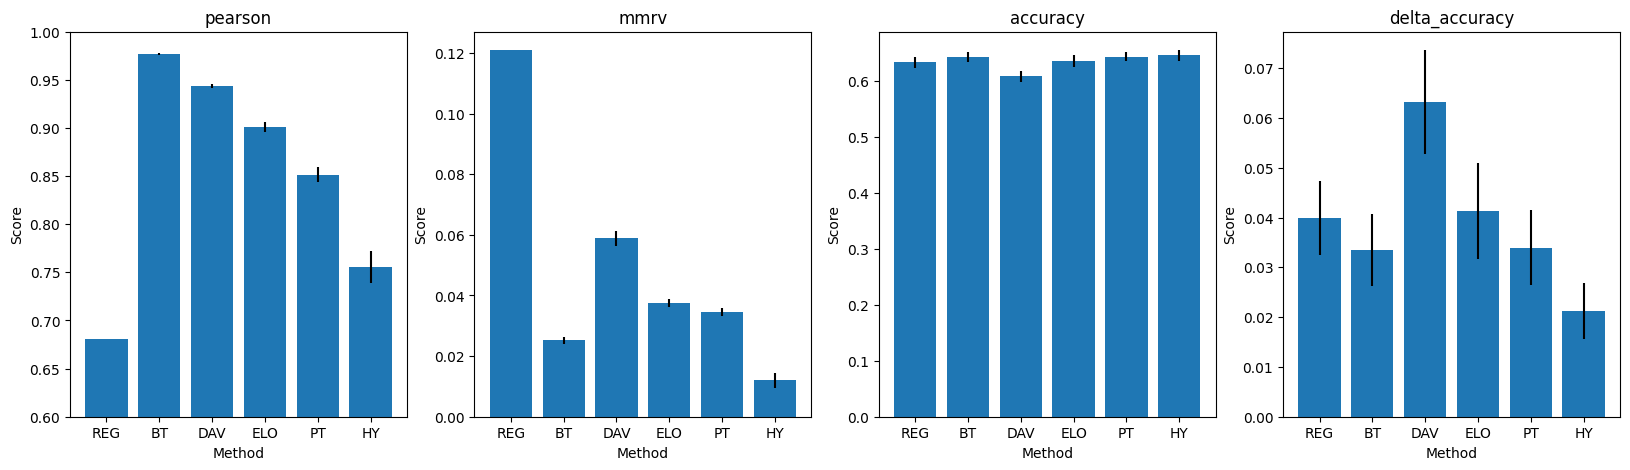

In [ ]:
# Plot metrics for all methods
import matplotlib.pyplot as plt

def df2dict(df):
    return {r.metric: (r.score, r["ci95"]) for _, r in df.iterrows()}

DATA = {
    "REG": df2dict(met_reg),
    "BT": df2dict(met_bt),
    "DAV": df2dict(met_dav),
    "ELO": df2dict(met_elo),
    "PT": df2dict(met_pt),
    "HY": df2dict(met_hy),
}

# Plot three side-by-side plots for pearson, mmrv, and accuracy with confidence
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["pearson", "mmrv", "accuracy", "delta_accuracy"]):
    axs[i].set_title(metric)
    axs[i].set_xlabel("Method")
    axs[i].set_ylabel("Score")
    axs[i].bar(DATA.keys(), [data[metric][0] for data in DATA.values()], yerr=[data[metric][1] for data in DATA.values()])
    if metric == "pearson":
      axs[i].set_ylim(0.6, 1)
plt.show()

# Where do progress and preference disagree?

In [ ]:
# check how often the partial success score does not agree with winner

n_total = 0
n_disagree = 0
for _, pref_info in pref_df.iterrows():
  pref = pref_info.y
  n_total += 1
  partial_success_A = task_df[(task_df.sid == pref_info.sid) & (task_df.policy == pref_info.i)].iloc[0]["partial_success"]
  partial_success_B = task_df[(task_df.sid == pref_info.sid) & (task_df.policy == pref_info.j)].iloc[0]["partial_success"]
  if pref == 2 and partial_success_A <= partial_success_B:
    n_disagree += 1
  elif pref == 1 and partial_success_A != partial_success_B:
    n_disagree += 1
  elif pref == 0 and partial_success_A >= partial_success_B:
    n_disagree += 1

print(f"Total: {n_total}")
print(f"Disagreement rate: {n_disagree / n_total}")

IndexError: single positional indexer is out-of-bounds

# Data Efficiency Simulation

In [ ]:
def data_efficiency_bootstrap(fn, use_pref=True, bootstrap_rounds=100, episode_counts=None):
  # Run algorithm over N random resamples of the data

  sid = np.unique(pref_df.sid)
  metrics = defaultdict(lambda: defaultdict(list))
  for _ in tqdm.tqdm(range(bootstrap_rounds)):
    rng.shuffle(sid)

    train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
    test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]

    train_data = train_pref
    test_data = test_pref
    if not use_pref:
      train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
      test_task  = task_df[~task_df.sid.isin(train_task.sid)]
      train_data = train_task

    assert episode_counts is not None, "need to specify n_episodes list"
    for n_episodes in episode_counts:
      sid_n = sid[:int(len(sid) * (1 - TEST_FR))][:n_episodes]
      train_data_n = train_data[train_data.sid.isin(sid_n)]

      # Run algorithm
      results = fn(train_data_n[:n_episodes])

      # Compute metrics
      merged = results.merge(gt, on="policy", how="inner")

      sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
      gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)
      acc = accuracy(test_data, results)
      gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
      metrics[n_episodes]["pearson"].append(pearson(sc_vals, gt_vals))
      metrics[n_episodes]["mmrv"].append(mmrv(sc_vals, gt_vals))
      metrics[n_episodes]["accuracy"].append(acc)
      metrics[n_episodes]["delta_accuracy"].append(max(gt_acc - acc, 0))

  return {k: pd.DataFrame(
      {
          "metric": metrics[k].keys(),
          "score": [np.mean(scores) for scores in metrics[k].values()],
          "std": [np.std(scores) for scores in metrics[k].values()],
          "ci95": [ci(scores) for scores in metrics[k].values()]
      }
    ) for k in metrics.keys()
  }


def data_efficiency_bootstrap_scoreavg(
    score_df,
    use_pref=True,
    bootstrap_rounds=100,
    episode_counts=None,
    policies_per_session=7
  ):
  # Run algorithm over N random resamples of the data

  sid = np.unique(pref_df.sid)
  metrics = defaultdict(lambda: defaultdict(list))
  for _ in tqdm.tqdm(range(bootstrap_rounds)):
    rng.shuffle(sid)

    train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
    test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]

    train_data = train_pref
    test_data = test_pref
    if not use_pref:
      train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
      test_task  = task_df[~task_df.sid.isin(train_task.sid)]
      train_data = train_task

    assert episode_counts is not None, "need to specify n_episodes list"
    for n_episodes in episode_counts:
      # Average scores
      if "session_id" in score_df.columns:
        data = []
        n_sids = []
        while (
            len(data) < n_episodes * 2 and len(n_sids) < int(len(sid) * (1 - TEST_FR))
        ):
          n_sids = sid[:len(n_sids) + 1]
          data = score_df[score_df.session_id.isin(n_sids)]
        data = data.sample(n=n_episodes * 2, replace=len(data) < n_episodes * 2) # times two since we are not doing pairs
      else:
        if n_episodes * 2 > len(score_df):
          data = score_df.sample(n=n_episodes * 2, replace=True)
        else:
          data = score_df.sample(n=n_episodes * 2)  # times two since we are not doing pairs
      results = pd.DataFrame(data.groupby("policy").mean().reset_index())

      # Compute metrics
      merged = results.merge(gt, on="policy", how="inner")

      sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
      gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)
      acc = accuracy(test_data, results)
      gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
      metrics[n_episodes]["pearson"].append(pearson(sc_vals, gt_vals))
      metrics[n_episodes]["mmrv"].append(mmrv(sc_vals, gt_vals))
      metrics[n_episodes]["accuracy"].append(acc)
      metrics[n_episodes]["delta_accuracy"].append(max(gt_acc - acc, 0))

  return {k: pd.DataFrame(
      {
          "metric": metrics[k].keys(),
          "score": [np.mean(scores) for scores in metrics[k].values()],
          "std": [np.std(scores) for scores in metrics[k].values()],
          "ci95": [ci(scores) for scores in metrics[k].values()]
      }
    ) for k in metrics.keys()
  }

In [ ]:
# Bradley-Terry
efficiency_met_bt = data_efficiency_bootstrap(bt_mm, episode_counts=[10, 15, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300])
# display(efficiency_met_bt)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [ ]:
# Hybrid EM
efficiency_met_hy = data_efficiency_bootstrap(em_hybrid, episode_counts=[10, 15, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300])
# display(efficiency_met_hy)

100%|██████████| 100/100 [13:22<00:00,  8.02s/it]


In [ ]:
def bootstrap_sampling(fn, use_pref=True, bootstrap_rounds=20, init_samples=10, resample_weights_steps=5, inner_bootstrap_ratio=0.8, inner_bootstrap_rounds=10, max_episodes=100):
  # Run algorithm over N random resamples of the data

  def update_sampling_weights(train_data_n, pols):
    # Bootstrap fn on current train data to derive uncertainty estimate
    current_sids = train_data_n.sid.unique()
    pol_scores = defaultdict(list)
    for _ in range(inner_bootstrap_rounds):
      rng.shuffle(current_sids)
      chosen_sids = current_sids[:int(len(current_sids) * inner_bootstrap_ratio)]
      mask = train_data_n.sid.isin(chosen_sids)
      train_data_n_inner = train_data_n[mask]
      results = fn(train_data_n_inner)
      for _, r in results.iterrows():
        pol_scores[r.policy].append(r.score)

    # Sample proportional to normalized std of policy scores
    sampling_weights = [np.std(pol_scores[p]) for p in pols]
    # Replace NaN weights
    sampling_weights = np.array(sampling_weights)
    sampling_weights[np.isnan(sampling_weights)] = 1
    # Normalize
    sampling_weights = sampling_weights / np.sum(sampling_weights)
    return sampling_weights

  def sample_session(pols, sampling_weights, train_data, train_data_n):
    unused_train_data = train_data[~train_data.sid.isin([train_data_n.sid])]

    # Sample policy A and B based on sampling probabilities
    indices = np.random.choice(
        len(pols),
        size=2,
        replace=False,
        p=sampling_weights
    )
    pol_a, pol_b = pols[indices[0]], pols[indices[1]]

    # Sample from all unused sessions with this matchup
    filtered_data = unused_train_data[
        (unused_train_data.i == pol_a) & (unused_train_data.j == pol_b)
        | (unused_train_data.i == pol_b) & (unused_train_data.j == pol_a)
    ]
    if len(filtered_data) == 0:
      return unused_train_data.sample(1)
    return filtered_data.sample(1)

  sid = np.unique(pref_df.sid)
  metrics = defaultdict(lambda: defaultdict(list))
  for _ in tqdm.tqdm(range(bootstrap_rounds), desc="Outer bootstrap"):
    rng.shuffle(sid)

    train_pref = pref_df[pref_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
    test_pref  = pref_df[~pref_df.sid.isin(train_pref.sid)]

    train_data = train_pref
    test_data = test_pref
    if not use_pref:
      train_task = task_df[task_df.sid.isin(sid[:int(len(sid) * (1 - TEST_FR))])]
      test_task  = task_df[~task_df.sid.isin(train_task.sid)]
      train_data = train_task

    # Initialize smart sampling with
    train_data_n = pd.DataFrame(columns=train_data.columns)
    pols = list(set(train_data.i.unique()) | set(train_data.j.unique()))
    sampling_weights = np.ones(len(pols)) / len(pols)
    for step in tqdm.tqdm(range(max_episodes), desc="Inner steps"):
      if len(train_data_n) >= init_samples and step % resample_weights_steps == 0:
        sampling_weights = update_sampling_weights(train_data_n, pols)
      new_sample = sample_session(pols, sampling_weights, train_data, train_data_n)
      if train_data_n.empty:
        train_data_n = new_sample
      else:
        train_data_n = pd.concat((train_data_n, new_sample))
      if len(train_data_n) < init_samples or step % resample_weights_steps != 0:
        continue

      # Run algorithm
      results = fn(train_data_n)

      # Compute metrics
      merged = results.merge(gt, on="policy", how="inner")

      sc_vals = pd.to_numeric(merged["score"], errors="coerce").to_numpy(dtype=float)
      gt_vals = pd.to_numeric(merged["gt"],    errors="coerce").to_numpy(dtype=float)
      acc = accuracy(test_data, results)
      gt_acc = accuracy(test_data, pd.DataFrame({"policy": merged.policy, "score": gt_vals}))
      metrics[step]["pearson"].append(pearson(sc_vals, gt_vals))
      metrics[step]["mmrv"].append(mmrv(sc_vals, gt_vals))
      metrics[step]["accuracy"].append(acc)
      metrics[step]["delta_accuracy"].append(max(gt_acc - acc, 0))

  return {k: pd.DataFrame(
      {
          "metric": metrics[k].keys(),
          "score": [np.mean(scores) for scores in metrics[k].values()],
          "std": [np.std(scores) for scores in metrics[k].values()],
          "ci95": [ci(scores) for scores in metrics[k].values()]
      }
    ) for k in metrics.keys()
  }

In [ ]:
efficiency_met_hy_smart_2 = bootstrap_sampling(em_hybrid)

Outer bootstrap: 100%|██████████| 20/20 [40:47<00:00, 122.38s/it]


In [ ]:
# Oracle Eval
eps["policy_canon"] = eps.policy_name.apply(canonical)
oracle_scores = (
    eps[~eps.policy_canon.str.upper().isin(EXCLUDE)][["session_id", "policy_canon", "partial_success"]]
    .reset_index()
    .rename(columns={"policy_canon": "policy", "partial_success": "score"})
)
efficiency_met_oracle = data_efficiency_bootstrap_scoreavg(oracle_scores, episode_counts=[10, 15, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300])

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


In [ ]:
# Standard Evaluation
standard_policy_names, standard_policy_scores = [], []
for policy, scores in standard_droid_results.items():
  standard_policy_names.extend([policy] * len(scores))
  standard_policy_scores.extend(scores)
# shuffle policy names and scores
shuffle_idx = rng.permutation(len(standard_policy_names))
standard_policy_names = [standard_policy_names[i] for i in shuffle_idx]
standard_policy_scores = [standard_policy_scores[i] for i in shuffle_idx]
standard_scores = pd.DataFrame({"policy": standard_policy_names, "score": standard_policy_scores})
efficiency_met_reg = data_efficiency_bootstrap_scoreavg(standard_scores, episode_counts=[10, 15, 20, 30, 40, 50, 60, 80, 100, 150, 200, 300])

100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


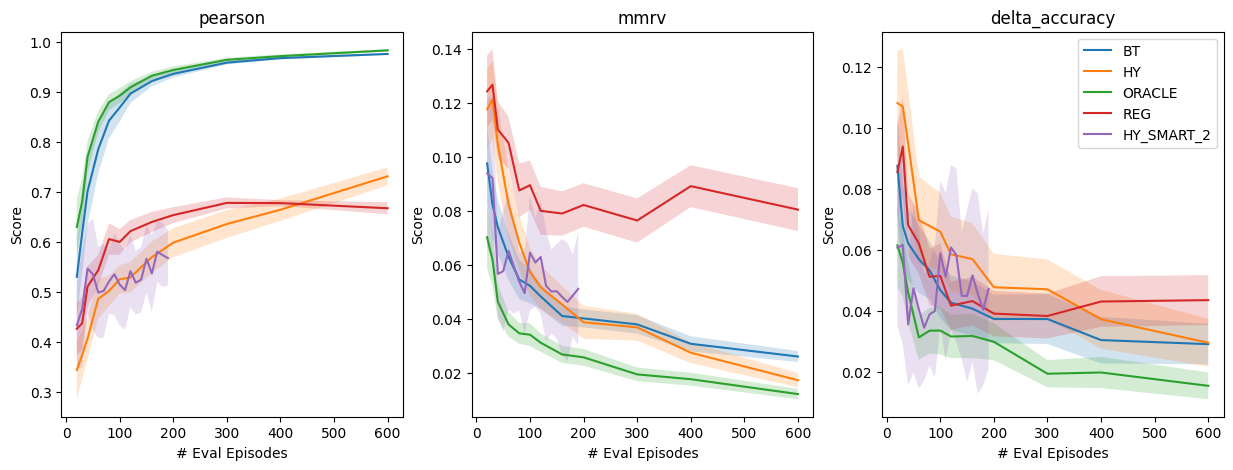

In [ ]:
# Plot metrics over time
import matplotlib.pyplot as plt

def df2dict(df):
    return {r.metric: (r.score, r["ci95"]) for _, r in df.iterrows()}

EFFICIENCY_DATA = {
    "BT": {k: df2dict(efficiency_met_bt[k]) for k in efficiency_met_bt.keys()},
    "HY": {k: df2dict(efficiency_met_hy[k]) for k in efficiency_met_hy.keys()},
    "ORACLE": {k: df2dict(efficiency_met_oracle[k]) for k in efficiency_met_oracle.keys()},
    "REG": {k: df2dict(efficiency_met_reg[k]) for k in efficiency_met_reg.keys()},
    "HY_SMART_2": {k: df2dict(efficiency_met_hy_smart_2[k]) for k in efficiency_met_hy_smart_2.keys()},
    # "HY_SMART": {k: df2dict(efficiency_met_hy_smart[k]) for k in efficiency_met_hy_smart.keys()},
}

# Plot three side-by-side plots for pearson, mmrv, and accuracy with confidence

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, metric in enumerate(["pearson", "mmrv", "delta_accuracy"]):
    axs[i].set_title(metric)
    axs[i].set_xlabel("# Eval Episodes")
    axs[i].set_ylabel("Score")
    for method, data in EFFICIENCY_DATA.items():
      # We multiply x-axis vals * 2 since we are counting eval *pairs*
      axs[i].plot([v * 2 for v in data.keys()], [data[k][metric][0] for k in data.keys()], label=method)
      if method != "HY_SMART":
        axs[i].fill_between(
            [v * 2 for v in data.keys()],
            [data[k][metric][0] - data[k][metric][1] for k in data.keys()],
            [data[k][metric][0] + data[k][metric][1] for k in data.keys()],
            alpha=0.2,
        )
plt.legend()
plt.show()